In [189]:
from BorderQuery import select_mungedata_simple, select_predictions
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import datetime as dt
import numpy as np
from dbhelper import PgDB

In [101]:
def plot_resid(resid):
    plt.figure(figsize=(16,4))
    plt.plot(resid)
    plt.axhline(0, color='r');
    
def get_resid(munger_id, crossing_id, start_date, end_date):
    actual = select_mungedata_simple(munger_id, crossing_id, start_date, end_date)
    predict = select_predictions(munger_id, 'v2.1', crossing_id, start_date, end_date)
    resid = actual.copy()
    resid.waittime = predict.waittime - actual.waittime
    return resid.groupby(resid.index.date).waittime.sum()

## Build up residuals for each crossing and year

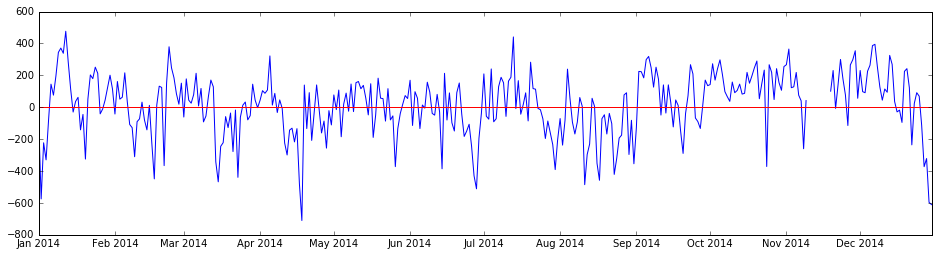

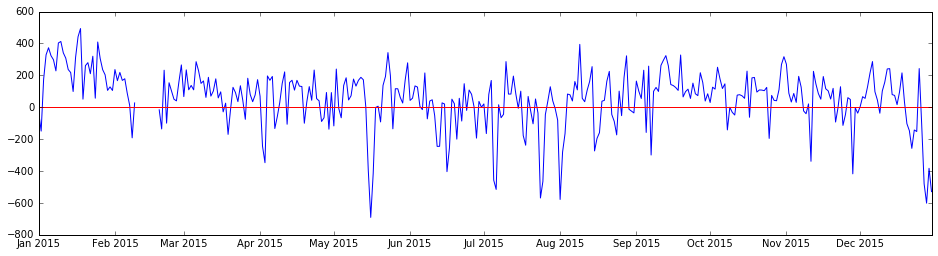

In [133]:
resid = { 1: {}, 2: {}, 5: {}, 6: {}}
munger_id = 3
crossing_id = 1
for year in range(2014, 2016):
    resid[crossing_id][year] = get_resid(munger_id, crossing_id, str(dt.date(year, 1, 1)), str(dt.date(year + 1, 1, 1)))
    plot_resid(resid[crossing_id][year])

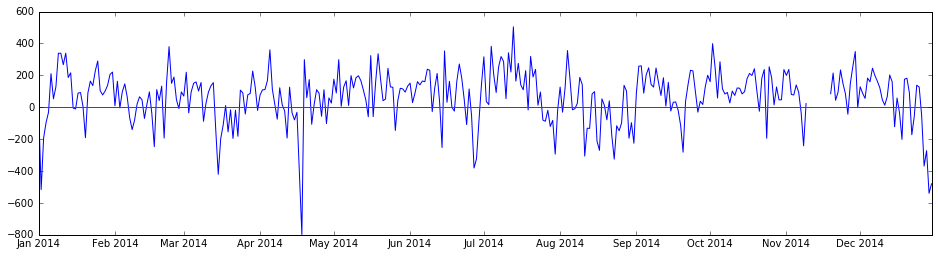

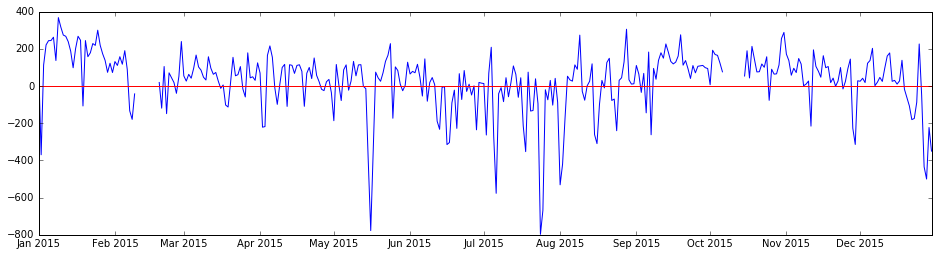

In [134]:
munger_id = 3
crossing_id = 5
for year in range(2014, 2016):
    resid[crossing_id][year] = get_resid(munger_id, crossing_id, str(dt.date(year, 1, 1)), str(dt.date(year + 1, 1, 1)))
    plot_resid(resid[crossing_id][year])

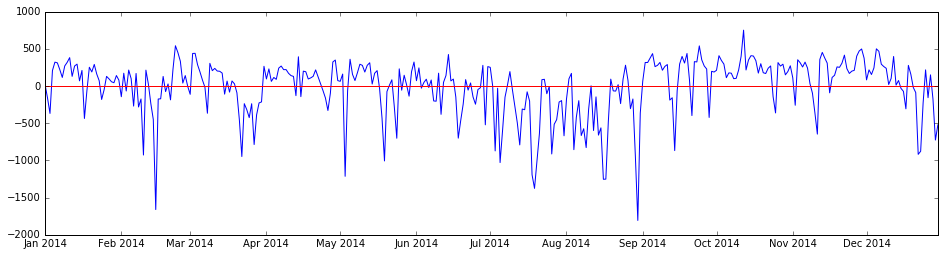

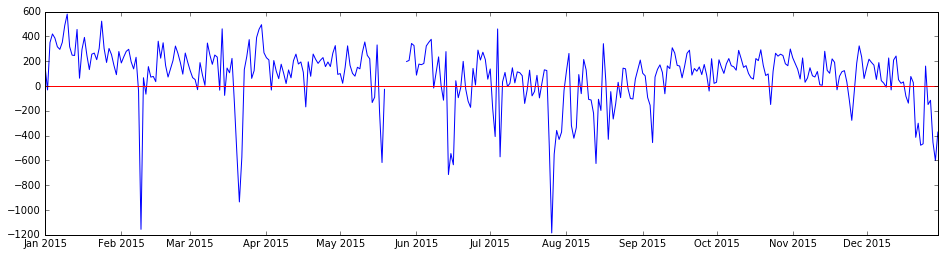

In [135]:
munger_id = 4
crossing_id = 2
for year in range(2014, 2016):
    resid[crossing_id][year] = get_resid(munger_id, crossing_id, str(dt.date(year, 1, 1)), str(dt.date(year + 1, 1, 1)))
    plot_resid(resid[crossing_id][year])

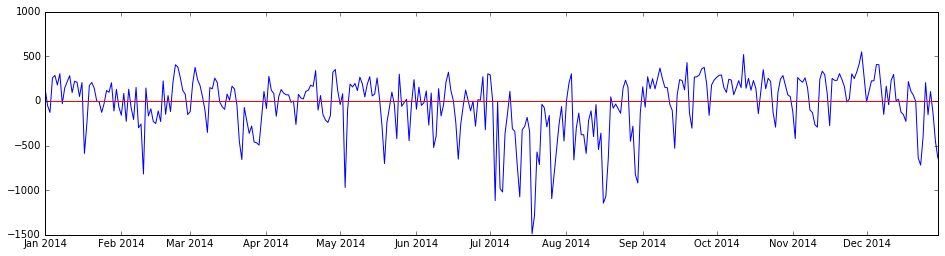

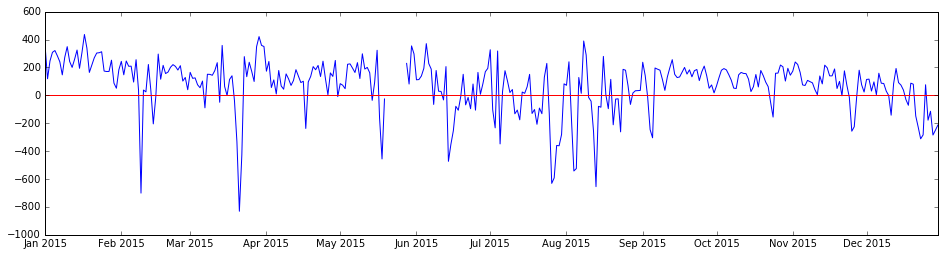

In [136]:
munger_id = 4
crossing_id = 6
for year in range(2014, 2016):
    resid[crossing_id][year] = get_resid(munger_id, crossing_id, str(dt.date(year, 1, 1)), str(dt.date(year + 1, 1, 1)))
    plot_resid(resid[crossing_id][year])

## Calculate correlation

In [137]:
resid_df = pd.DataFrame()
for xing in [1,2,5,6]:
    for year in [2014, 2015]:
        col = '{0}_{1}'.format(xing, year)
        resid[xing][year].index = pd.to_datetime(resid[xing][year].index)
        if year == 2015:
            resid[xing][year].index = pd.to_datetime(resid[xing][year].index) - pd.DateOffset(days=365)
        
        resid_df[col] = resid[xing][year] 

In [138]:
resid_df.corr()

,1_2014,1_2015,2_2014,2_2015,5_2014,5_2015,6_2014,6_2015
1_2014,1.000000,0.239884,0.283925,0.254127,0.884265,0.257634,0.219869,0.231505
1_2015,0.239884,1.000000,0.207006,0.334124,0.197195,0.917302,0.182716,0.273540
2_2014,0.283925,0.207006,1.000000,0.325363,0.155033,0.204250,0.902677,0.366090
2_2015,0.254127,0.334124,0.325363,1.000000,0.229643,0.308955,0.329339,0.886983
5_2014,0.884265,0.197195,0.155033,0.229643,1.000000,0.197005,0.095553,0.207240
5_2015,0.257634,0.917302,0.204250,0.308955,0.197005,1.000000,0.197954,0.249847
6_2014,0.219869,0.182716,0.902677,0.329339,0.095553,0.197954,1.000000,0.361213
6_2015,0.231505,0.273540,0.366090,0.886983,0.207240,0.249847,0.361213,1.000000


## Analysis
* Crossings in same direction are strongly correlated for same year - Not actionable
* Northbound correlation between years relatively strong - Suggests there is some factor that is not accounted for

## Start with PH North which has strongest cross-year correlation

In [156]:
resid_delta = resid[2][2015] - resid[2][2014]

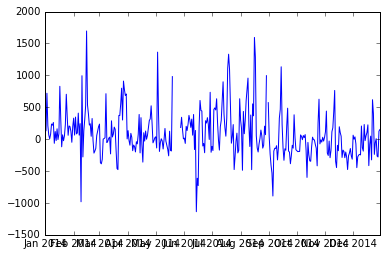

In [157]:
plt.plot(resid_delta)

In [158]:
resid_delta.sort_values(ascending=False).head(10)

2014-02-15    1696.006261
2014-08-16    1595.153226
2014-05-03    1364.500670
2014-07-19    1331.943244
2014-08-17    1287.799971
2014-09-14    1134.530079
2014-07-18    1112.610382
2014-07-20    1090.773300
2014-08-29     994.946687
2014-02-10     994.541592
Name: waittime, dtype: float64

In [149]:
resid[6][2015].mean()

73.80685073205242

In [150]:
resid[6][2014].mean()

-38.02761045665663

In [152]:
np.sqrt(np.square(resid[6][2015])).mean()

163.89576147023277

In [153]:
np.sqrt(np.square(resid[6][2014])).mean()

237.8450063463944

In [154]:
resid_delta = resid[6][2015]/164 - resid[6][2014]/238

In [155]:
resid_delta.sort_values(ascending=False).head(10)

2014-08-16    6.512630
2014-07-18    5.460394
2014-01-17    5.131298
2014-07-19    4.768941
2014-03-29    4.645963
2014-08-17    4.525531
2014-07-06    4.454095
2014-05-03    4.366169
2014-08-09    4.233719
2014-03-28    4.099002
Name: waittime, dtype: float64

In [160]:
def resid_delta(resid1, resid2):
    resid1 = resid1 - resid1.mean()
    resid2 = resid2 - resid2.mean()
    return resid1 / np.absolute(resid1).mean() - resid2 / np.absolute(resid2).mean()

temp = resid_delta(resid[6][2015], resid[6][2014])

In [168]:
for xing in [1, 5, 2, 6]:
    print "*" * 10, xing, "*" * 10
    print resid_delta(resid[xing][2015], resid[xing][2014]).sort_values(ascending=False).head(10)

********** 1 **********
2014-04-18    5.300106
2014-01-18    4.415443
2014-01-04    4.361151
2014-02-21    3.845670
2014-04-17    3.810220
2014-01-20    3.800017
2014-03-14    3.266819
2014-09-19    3.181028
2014-03-15    3.156462
2014-01-05    3.090698
Name: waittime, dtype: float64
********** 5 **********
2014-04-18    7.515379
2014-04-17    4.639098
2014-01-20    4.030772
2014-03-15    3.959707
2014-09-19    3.671158
2014-09-20    3.587090
2014-06-27    3.405727
2014-10-24    3.280183
2014-03-21    3.261063
2014-12-18    3.165492
Name: waittime, dtype: float64
********** 2 **********
2014-08-16    5.989535
2014-02-15    5.595213
2014-05-03    4.699716
2014-09-14    4.166291
2014-08-17    4.145125
2014-07-19    4.104497
2014-07-20    3.566527
2014-01-17    3.386720
2014-01-24    3.264878
2014-03-25    3.237339
Name: waittime, dtype: float64
********** 6 **********
2014-08-16    6.081287
2014-01-17    4.956043
2014-03-29    4.458414
2014-07-18    4.456064
2014-08-09    3.862821
2014-0

### Discovered interesting dates
* Northbound: 8/16(exact), 1/17(already coded as MLK?), 7/18 (3rd Sat in Jul)
* Southbound: 4/18(exact), 1/20(already coded as MLK?), 3/14(2nd Sat in Mar), 9/19(3rd Fri in Sep)

In [187]:
def get_nth_weekday(year, month, dow, n):
    '''
    dow: Monday = 0
    n: nth occurence
    '''
    first_day = dt.date(year, month, 1)
    first_day_dow = first_day.weekday()
    if first_day_dow > dow:
        delta_to_first_dow = 7 + dow - first_day_dow
    else:
        delta_to_first_dow = dow - first_day_dow
    
    new_day = 7 * (n - 1) + delta_to_first_dow + 1
    
    return dt.date(year, month, new_day)

get_nth_weekday(2015, 7, 5, 3)

datetime.date(2015, 7, 18)

In [192]:
dates = {}
dates['Aug_16'] = ['{0}-8-16'.format(year) for year in range(2007, 2019)]
dates['Apr_17'] = ['{0}-4-17'.format(year) for year in range(2007, 2019)]  # shift by one day due to Good Friday conflict
dates['Jul_3rdSat'] = [str(get_nth_weekday(year, 7, 5, 3)) for year in range(2007, 2019)]
dates['Mar_2ndSat'] = [str(get_nth_weekday(year, 3, 5, 2)) for year in range(2007, 2019)]
dates['Sep_3rdFri'] = [str(get_nth_weekday(year, 7, 4, 3)) for year in range(2007, 2019)]
dates

{'Apr_17': ['2007-4-17',
  '2008-4-17',
  '2009-4-17',
  '2010-4-17',
  '2011-4-17',
  '2012-4-17',
  '2013-4-17',
  '2014-4-17',
  '2015-4-17',
  '2016-4-17',
  '2017-4-17',
  '2018-4-17'],
 'Aug_16': ['2007-8-16',
  '2008-8-16',
  '2009-8-16',
  '2010-8-16',
  '2011-8-16',
  '2012-8-16',
  '2013-8-16',
  '2014-8-16',
  '2015-8-16',
  '2016-8-16',
  '2017-8-16',
  '2018-8-16'],
 'Jul_3rdSat': ['2007-07-21',
  '2008-07-19',
  '2009-07-18',
  '2010-07-17',
  '2011-07-16',
  '2012-07-21',
  '2013-07-20',
  '2014-07-19',
  '2015-07-18',
  '2016-07-16',
  '2017-07-15',
  '2018-07-21'],
 'Mar_2ndSat': ['2007-03-10',
  '2008-03-08',
  '2009-03-14',
  '2010-03-13',
  '2011-03-12',
  '2012-03-10',
  '2013-03-09',
  '2014-03-08',
  '2015-03-14',
  '2016-03-12',
  '2017-03-11',
  '2018-03-10'],
 'Sep_3rdFri': ['2007-07-20',
  '2008-07-18',
  '2009-07-17',
  '2010-07-16',
  '2011-07-15',
  '2012-07-20',
  '2013-07-19',
  '2014-07-18',
  '2015-07-17',
  '2016-07-15',
  '2017-07-21',
  '2018-07-20'

In [193]:
query = '''
        insert into specialdates
        values ('{0}', 'yy', '{1}');
        '''

with PgDB() as db:
    for event, datelist in dates.items():
        for d in datelist:
            db.cur.execute(query.format(d, event))
    db.conn.commit()